In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re, string
import pickle
from sklearn.externals import joblib
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from score import calc_auc_score, calc_log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

## Take Input

In [39]:
# read the train and test data
def readInputFiles(train_file_path, test_file_path):
    train = pd.read_csv(train_file_path)
    test = pd.read_csv(test_file_path)
    return train, test
    
train, test = readInputFiles('./dataset/train_new.csv', './dataset/test_new.csv')

In [107]:
red = "#EE586A" # Use for toxic
green = "#5AC77F" # Use for clean

blue = "#20c5b9"
pale = "#E2E7AF"
orange = "#F9BF7D"
ugly_green = "#9e9f3c"
brown = "#ac6b58"

grey = "#303847"

colors_list = [red, blue, orange, pale,
            ugly_green, brown]
colors_list_clean = [green, red, blue, orange, pale,
            ugly_green, brown ]

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', [red, blue])

## Comment Length (X) vs No of Comments (Y)

Grandma Terri Should Burn in Trash 
Grandma Terri is trash. I hate Grandma Terri. F%%K her to HELL! 71.74.76.40

Average length of comments: 395
Standard dev: 594
Longest Comment: 5895

# Comments in train data: 127656 
# Comments in test data: 31915


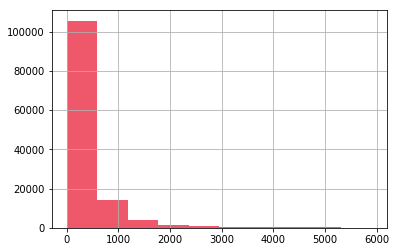

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,140030,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0
1,159124,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0
2,60006,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0
3,65432,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0
4,154979,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0


In [35]:
def dataExploration(trainData):   
    # look at the top five rows of the train data file
    # training data contains a row per comment, with an id, 
    # the text of the comment, and 6 different labels
    trainData.head()
    
    # exampel of a comment in the train data
    print (trainData['comment_text'][0])
    print ("")
    
    # the length of the comments varies a lot   
    lens = trainData.comment_text.str.len()
    print("Average length of comments: %d\nStandard dev: %d\nLongest Comment: %d" % (lens.mean(), lens.std(), lens.max()))
    
    print ("")
    print ("# Comments in train data: %d \n# Comments in test data: %d" % (len(train),len(test)))
    lens.hist(color=red)
    plt.show()
    
dataExploration(train)
train.head()

# Comment Length vs Toxic Class

In [5]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

colors = ('b','g','r','c','m','y')

f, axes = plt.subplots(1, 6, sharey=True, figsize=(15,5))
f.suptitle('Comment Length vs Toxic')

for i, label in enumerate(labels):
    
    data = train.groupby(label).mean()['length']
    
    axes[i].bar(data.index.values, data, width=0.5, color=colors[i])
    
    axes[i].set_xlabel(label)
    
plt.show()

KeyError: 'length'

# Toxic Class Frequency

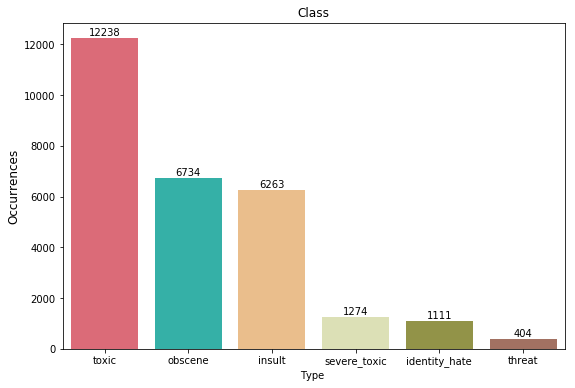

In [41]:
colors_list = [red, blue, orange, pale,
            ugly_green, brown]

palette= sns.color_palette(colors_list)

x=train.iloc[:,3:].sum()
x = x.sort_values(ascending=False)
plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

# Toxic Class Frequency including Clean 

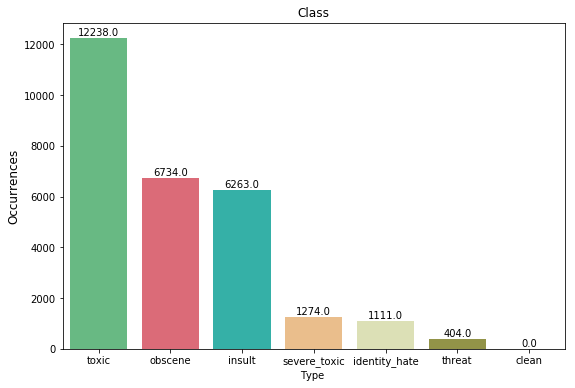

In [51]:
rowsums=train.iloc[:,3:].sum(axis=1)
train['clean']=(rowsums==0)
train['clean'].sum()

palette= sns.color_palette(colors_list_clean)

x=train.iloc[:,3:].sum()
x = x.sort_values(ascending=False)
plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

# Word Clouds

In [108]:
toxic=train[train.toxic==1]['comment_text'].values
severe_toxic=train[train.severe_toxic==1]['comment_text'].values
obscene=train[train.obscene==1]['comment_text'].values
threat=train[train.threat==1]['comment_text'].values
insult=train[train.insult==1]['comment_text'].values
identity_hate=train[train.identity_hate==1]['comment_text'].values

## The wordcloud of Toxic Comments


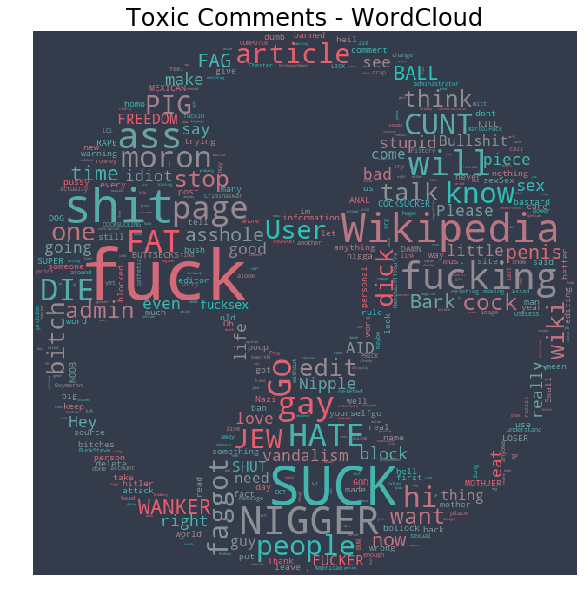

In [118]:
mask=np.array(Image.open('toxic_logo.jpg'))
mask=mask[:,:,1]
# The wordcloud of Toxic Comments
plt.figure(figsize=(10,10))
wc = WordCloud(background_color=grey, max_words=400, mask=mask
             , stopwords=STOPWORDS, max_font_size= 80, collocations=False)
wc.generate(" ".join(toxic))
plt.title("Toxic Comments - WordCloud", fontsize=24)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= cmap, random_state=1), alpha=0.98)
plt.axis('off')
plt.show()

## The wordcloud of Severe Toxic Comments


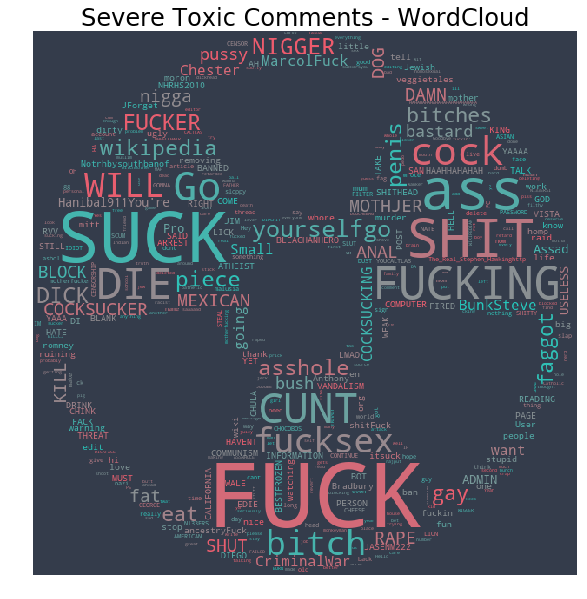

In [116]:
plt.figure(figsize=(10,10))
wc = WordCloud(background_color=grey, max_words=400, mask=mask
             , stopwords=STOPWORDS, max_font_size= 80, collocations=False)
wc.generate(" ".join(severe_toxic))
plt.title("Severe Toxic Comments - WordCloud", fontsize=24)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= cmap, random_state=1), alpha=0.98)
plt.axis('off')
plt.show()

## The wordcloud of Threat Comments


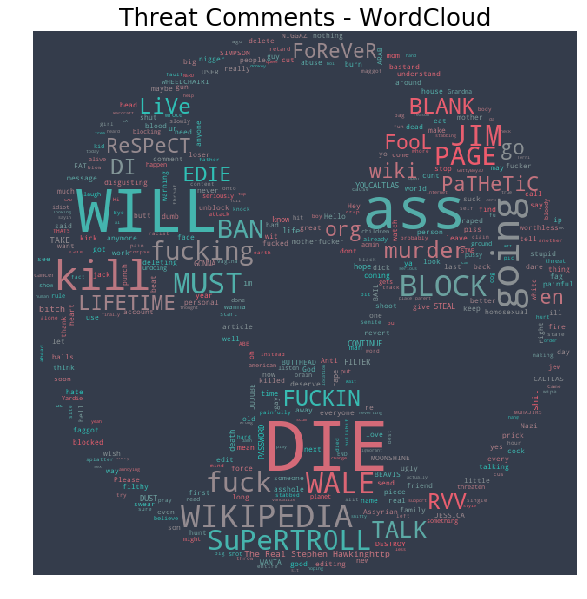

In [119]:
# The wordcloud of Toxic Comments
plt.figure(figsize=(10,10))
wc = WordCloud(background_color=grey, max_words=400, mask=mask
             , stopwords=STOPWORDS, max_font_size= 80, collocations=False)
wc.generate(" ".join(threat))
plt.title("Threat Comments - WordCloud", fontsize=24)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= cmap, random_state=1), alpha=0.98)
plt.axis('off')
plt.show()

## The wordcloud of Obscene Comments


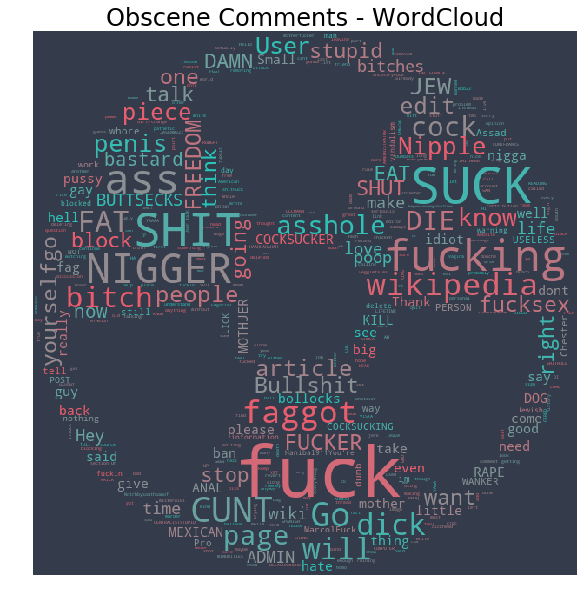

In [120]:
# The wordcloud of Toxic Comments
plt.figure(figsize=(10,10))
wc = WordCloud(background_color=grey, max_words=400, mask=mask
             , stopwords=STOPWORDS, max_font_size= 80, collocations=False)
wc.generate(" ".join(obscene))
plt.title("Obscene Comments - WordCloud", fontsize=24)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= cmap, random_state=1), alpha=0.98)
plt.axis('off')
plt.show()

## The wordcloud of Insult Comments


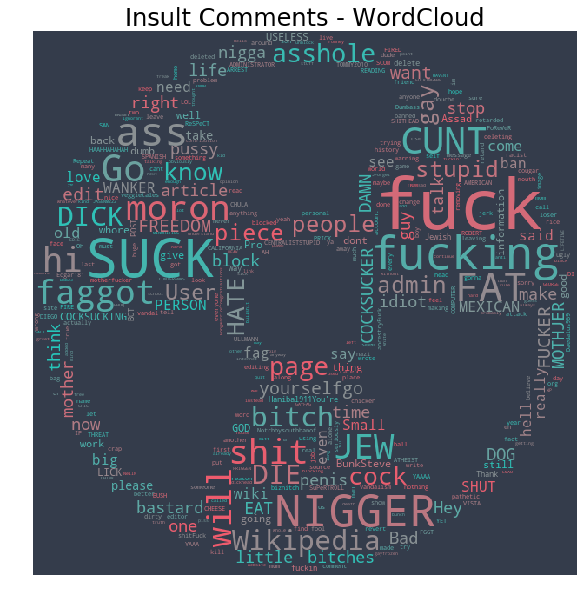

In [123]:
# The wordcloud of Toxic Comments
plt.figure(figsize=(10,10))
wc = WordCloud(background_color=grey, max_words=400, mask=mask
             , stopwords=STOPWORDS, max_font_size= 80, collocations=False)
wc.generate(" ".join(insult))
plt.title("Insult Comments - WordCloud", fontsize=24)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= cmap, random_state=1), alpha=0.98)
plt.axis('off')
plt.show()

In [ ]:
## The wordcloud of Identity Hate Comments

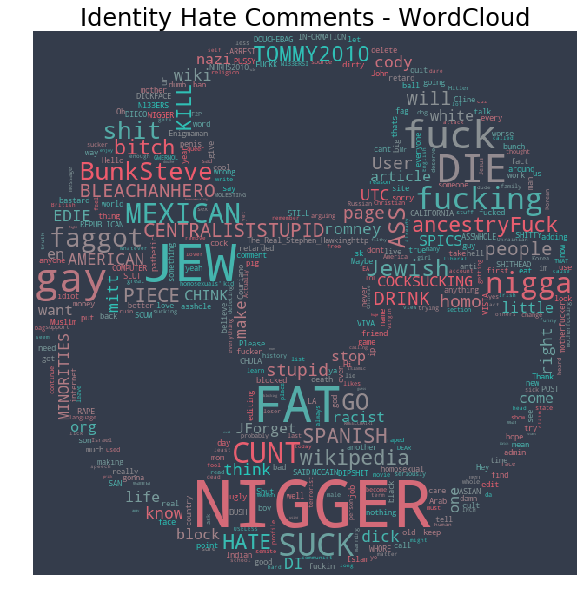

In [124]:
plt.figure(figsize=(10,10))
wc = WordCloud(background_color=grey, max_words=400, mask=mask
             , stopwords=STOPWORDS, max_font_size= 80, collocations=False)
wc.generate(" ".join(identity_hate))
plt.title("Identity Hate Comments - WordCloud", fontsize=24)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= cmap, random_state=1), alpha=0.98)
plt.axis('off')
plt.show()